# Project 2

 
# Part 1 – Feedforward Neural Network (FNN)

**(a) Implement an FNN for approximating the solutions of 2D Poisson equations**

We will outline the key components of the class of Feedforward Neural Network, including:

        - The activation function
        - The loss function
        - The forward propagation
        - The backward propagation
        - The gradient descent algorithm

Following these descriptions, we will present the complete implementation of the Feedforward Neural Network and analysis.

**1. Activation Function:**

The activation function introduces non-linearity, enabling the network to learn complex patterns and relationships in data. And the derivative of the activation function is used during backpropagation to compute gradients.

The following three activation functions and their derivatives are implemented in the class `FeedforwardNeuralNetwork`:

-  ReLU (Rectified Linear Unit)       
- tanh (Hyperbolic Tangent)
- sigmoid (Logistic Function)
 

```python
def activation(self, z):  
        if self.activation_type == "relu":
            return np.maximum(0, z)
        elif self.activation_type == "sigmoid":
            return 1 / (1 + np.exp(-z))
        elif self.activation_type == "tanh":
            return np.tanh(z)
        else:
            raise Exception("Invalid activation function")

def activation_derivative(self, z):
    if self.activation_type == "relu":
        return (z > 0).astype(float)
    elif self.activation_type == "sigmoid":
        s = 1 / (1 + np.exp(-z))
        return s * (1 - s)
    elif self.activation_type == "tanh":
        t = np.tanh(z)
        return 1 - t**2
    else:
        raise Exception("Invalid activation function")
```

**2. Loss Function:**

The loss function quantifies the difference between the network’s predicted outputs (𝑦_pred) and the true values (𝑦_train).
We use the Mean Squared Error (MSE) loss function:
    
- Mean Squared Error (MSE):

$$MSE = \frac 1𝑛  \sum_{i=1}^{n} \|{𝑦_{pred}}^i, {𝑦_{train}}^𝑖\|²$$

            

```python
def compute_cost(self, y_pred, y_train):    
    return np.mean((y_pred - y_train)**2)
```

**3. Forward Propagation:**

Forward propagation passes input data through each layer of the network to generate output predictions.  

- Layer-wise Computation:
  - Linear transformation: $$𝑧[𝑙] = 𝑊[𝑙]𝑎[𝑙−1] + 𝑏[𝑙]$$
  - Activation function: $$𝑎[𝑙] = 𝑓(𝑧[𝑙])$$       

- Return of forward propagation:

    - Pre-activations ($z[l]$):
      Linear transformations before activation in each layer.
      
    - Activations ($a[l]$):
      Output of each layer.
 
                         
    - These values are stored for each layer and later used during backpropagation and infer.

```python
def feedforward(self, x):
    a_values = [x] # values after activation functions
    z_values = [] # values before activation functions
    for w, b in zip(self.weights, self.biases):
        z = np.dot(w, a_values[-1]) + b
        z_values.append(z)
        a = self.activation(z) if len(z_values) < self.num_layers - 1 else z
        a_values.append(a)
    return a_values, z_values
```

**4. Backward propagation**

Backward propagation computes the gradients of the loss function with respect to the weights and biases using the chain rule. The process starts from the output layer and propagates the gradients backward through the network. For the output layer, the gradient of the loss with respect to the predictions is directly computed. For hidden layers, the gradients are obtained by applying the chain rule and the derivative of the activation function. These gradients are used to update the parameters during optimization.

The method computes:

        - Gradients of the loss with respect to the weights 𝑊 and biases 𝑏 for each layer.
        - Gradients propagate backward layer by layer using the activation function's derivative (e.g., ReLU).
    
The gradients are stored in reverse order to simplify computation and are then returned in the correct order.

```python
def loss_gradient(self, y_pred, y_true):
    # return the gradient of loss w.r.t y_pred
    return 2 * (y_pred - y_true) / y_true.shape[1]

def backpropagate(self, z_values, a_values, loss_grad):
    # Initialize lists to store gradients for weights and biases
    w_gradient = []
    b_gradient = []

    # Compute gradients for the output layer and corresponding weights & biases first, 
    # as no activation function is applied in the output layer
    # z_gradient represents the gradient of the loss w.r.t y_pred
    z_gradient = loss_grad
    w_gradient.append(z_gradient @ a_values[-2].T) # shape = {1, a_{L-1}}
    b_gradient.append(np.sum(z_gradient, axis = -1)[:,None]) # shape = {1, 1}

    # Compute gradients for the remaining layers 
    for l in range(2, self.num_layers):

        # Compute the gradient of the activation function
        act_de = self.activation_derivative(z_values[-l]) # shape = {a_{-l}, batch_size}

        # Compute the gradient of the loss w.r.t pre-activation values of the current layer
        z_gradient = self.weights[-l + 1].T @ z_gradient * act_de # shape = {a_{-l}, batch_size}

         # Compute the gradient of the loss w.r.t weights and biases for the current layer
        w_gradient.append(z_gradient @ a_values[-l - 1].T) # shape = {a_{-l}, a_{-l - 1}}
        b_gradient.append(np.sum(z_gradient, axis = -1)[:,None]) # shape = {a_{-l}, 1}
        
    return w_gradient[::-1], b_gradient[::-1]
```

**5. Gradient descent algorithm**

We use gradient-based optimization methods, including Mini-batch Gradient Descent Method (`opt_type = "sgd"`) and Adam Optimizer (`opt_type = "adam"`) to minimize the loss function.

- **SGD**: Updates the parameters using the gradients directly with a fixed learning rate.
- **Adam**: Updates the parameters using momentum (first moment) and adaptive learning rates based on the second moment (variance) of the gradients.
    
The parameter updates are performed as follows:

```python
def update_parameters(self, nabla_w, nabla_b, learning_rate, opt_type = "sgd"):
    if opt_type == "sgd":
        self.weights = [w - learning_rate * dw for w, dw in zip(self.weights, nabla_w)]
        self.biases = [b - learning_rate * db for b, db in zip(self.biases, nabla_b)]
    elif opt_type == "adam":
        if not hasattr(self, "adm_step"):
            self.adm_step = 1
            self.w_f = [np.zeros_like(w) for w in self.weights] # 1st order moment for weights 
            self.w_s = [np.zeros_like(w) for w in self.weights] # 2nd order moment for weights
                
            self.b_f = [np.zeros_like(b) for b in self.biases] # 1st order moment for biases
            self.b_s = [np.zeros_like(b) for b in self.biases] # 2nd order moment for biases
            
        # initial parameters
        eps = 1e-10
        beta1 = 0.9
        beta2 = 0.999
        factor1 = 1 - beta1**self.adm_step
        factor2 = 1 - beta2**self.adm_step
            
        for i in range(len(nabla_w)):
            self.b_f[i] = beta1 * self.b_f[i] + (1-beta1) * nabla_b[i]
            self.w_f[i] = beta1 * self.w_f[i] + (1-beta1) * nabla_w[i]
            
            self.b_s[i] = beta2 * self.b_s[i] + (1-beta2) * (nabla_b[i]**2)
            self.w_s[i] = beta2 * self.w_s[i] + (1-beta2) * (nabla_w[i]**2)
            
            b_f_hat = self.b_f[i]/factor1
            w_f_hat = self.w_f[i]/factor1
            
            b_s_hat = self.b_s[i]/factor2
            w_s_hat = self.w_s[i]/factor2
                
            self.weights[i] -= learning_rate * w_f_hat / (eps + np.sqrt(w_s_hat))
            self.biases[i] -= learning_rate * b_f_hat / (eps + np.sqrt(b_s_hat))
        self.adm_step +=1
    else:
        raise Exception(f"Invalid optimization type {opt_type}. Supported types: \"sgd\", \"adam\".")
```       

**Complete Python implementation of the FNN:**

In [2]:
from matplotlib import pyplot as plt
import numpy as np

def visualization_2D(x, y, u, title):
    plt.figure(figsize=(8, 6))
    plt.tricontourf(x, y, u, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
class FeedforwardNeuralNetwork:
    def __init__(self, layer_sizes, activation_type = "relu"):
        """
        Initializes the Feedforward Neural Network with the given layer sizes and activation function.
        
        Parameters:
        - layer_sizes (list): list specifying number of neurons in each layer, like [2,8,1]
        
        - activation_type (str): "relu", "sigmoid", or "tanh".
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        if activation_type in ["relu", "sigmoid", "tanh"]:
            self.activation_type = activation_type
        else:
            raise ValueError(f"Invalid activation function '{activation_type}'. Supported types: relu, sigmoid, tanh.")
        self.weights = []
        self.biases = []
        
        # initialize all weights with N(0,1) * 0.01
        # Initialize all biases with 0
        for i in range(1, len(self.layer_sizes)):
            self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i - 1]) * 0.01)
            self.biases.append(np.zeros((self.layer_sizes[i], 1)))

    def activation(self, z):
        """
        Activation functions
        """
        if self.activation_type == "relu":
            return np.maximum(0, z)
        elif self.activation_type == "sigmoid":
            return 1 / (1 + np.exp(-z))
        elif self.activation_type == "tanh":
            return np.tanh(z)
        else:
            raise Exception("Invalid activation function")

    def activation_derivative(self, z):
        """
        Derivative of activation functions
        """
        if self.activation_type == "relu":
            return (z > 0).astype(float)
        elif self.activation_type == "sigmoid":
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        elif self.activation_type == "tanh":
            t = np.tanh(z)
            return 1 - t**2
        else:
            raise Exception("Invalid activation function")

    def feedforward(self, x):
        """
        Forward Propogation of Neural Network
        Parameters:
        - x (np.ndarray): The input data matrix with shape = {# features, # samples}.
        
        Returns:
        - a_values (list of ndarray): list of post-activation values in each layer, including input data.
        - z_values (list of ndarray): list of pre-activation values in each layer
        """
        a_values = [x] # values after activation functions
        z_values = [] # values before activation functions
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, a_values[-1]) + b
            z_values.append(z)
            a = self.activation(z) if len(z_values) < self.num_layers - 1 else z
            a_values.append(a)
        return a_values, z_values

    @staticmethod
    def compute_cost(y_pred, y_train):
        """
        Compute MSE loss function
        Parameters:
        - y_pred (np.ndarray): Predicted outputs with shape = {output_dim, # samples}.
        - y_train (np.ndarray): True labels with shape = {output_dim, # samples}.

        Returns:
        - cost (float): The mean squared error cost.
        """
        
        return np.mean((y_train - y_pred)**2)

    @staticmethod
    def loss_gradient(y_pred, y_true):
        """
        Derivative of MSE loss function
        """
        return 2 * (y_pred - y_true) / y_true.shape[1]

    def backpropagate(self, z_values, a_values, loss_grad):
        """
        Computes the gradients of the weights and biases for backpropagation.

        Parameters:
        - z_values (list of np.ndarray): Pre-activation values (z) of each layer.
        - a_values (list of np.ndarray): Post-activation values (a) of each layer, including input data.
        - loss_grad (ndarray): Gradient of the loss w.r.t y_pred.

        Returns:
        - w_gradient (list of np.ndarray): Gradients of the weights for all layers.
        - b_gradient (list of np.ndarray): Gradients of the biases for all layers.
        """
        w_gradient = []
        b_gradient = []
        
        z_gradient = loss_grad
        w_gradient.append(z_gradient @ a_values[-2].T) # shape = {1, a_{L-1}}
        b_gradient.append(np.sum(z_gradient, axis = -1)[:,None]) # shape = {1, 1}
        
        for l in range(2, self.num_layers):
            
            act_de = self.activation_derivative(z_values[-l]) # shape = {a_{-l}, batch_size}
            
            z_gradient = self.weights[-l + 1].T @ z_gradient * act_de # shape = {a_{-l}, batch_size}
            
            w_gradient.append(z_gradient @ a_values[-l - 1].T) # shape = {a_{-l}, a_{-l - 1}}
            
            b_gradient.append(np.sum(z_gradient, axis = -1)[:,None]) # shape = {a_{-l}, 1}
            
        return w_gradient[::-1], b_gradient[::-1]

    def update_parameters(self, nabla_w, nabla_b, learning_rate, opt_type = "sgd"):
        """
        Updates the weights and biases of the network using mini-batch .

        Parameters:
        - nabla_w (list of ndarray): Gradients of the weights for all layers.
        - nabla_b (list of ndarray): Gradients of the biases for all layers.
        - learning_rate (float): The step size for updating the parameters.
        - opt_type (str): The optimization method to use. Supported options:
                          - "sgd": Stochastic Gradient Descent.
                          - "adam": Adaptive Moment Estimation (Adam).
        """
        if opt_type == "sgd":
            self.weights = [w - learning_rate * dw for w, dw in zip(self.weights, nabla_w)]
            self.biases = [b - learning_rate * db for b, db in zip(self.biases, nabla_b)]
        elif opt_type == "adam":
            if not hasattr(self, "adm_step"):
                self.adm_step = 1
                self.w_f = [np.zeros_like(w) for w in self.weights] # 1st order moment for weights 
                self.w_s = [np.zeros_like(w) for w in self.weights] # 2nd order moment for weights
                
                self.b_f = [np.zeros_like(b) for b in self.biases] # 1st order moment for biases
                self.b_s = [np.zeros_like(b) for b in self.biases] # 2nd order moment for biases
            
            # initial parameters
            eps = 1e-10
            beta1 = 0.9
            beta2 = 0.999
            factor1 = 1 - beta1**self.adm_step
            factor2 = 1 - beta2**self.adm_step
            
            for i in range(len(nabla_w)):
                self.b_f[i] = beta1 * self.b_f[i] + (1-beta1) * nabla_b[i]
                self.w_f[i] = beta1 * self.w_f[i] + (1-beta1) * nabla_w[i]
                
                self.b_s[i] = beta2 * self.b_s[i] + (1-beta2) * (nabla_b[i]**2)
                self.w_s[i] = beta2 * self.w_s[i] + (1-beta2) * (nabla_w[i]**2)
                
                b_f_hat = self.b_f[i]/factor1
                w_f_hat = self.w_f[i]/factor1
                
                b_s_hat = self.b_s[i]/factor2
                w_s_hat = self.w_s[i]/factor2
                
                self.weights[i] -= learning_rate * w_f_hat / (eps + np.sqrt(w_s_hat))
                self.biases[i] -= learning_rate * b_f_hat / (eps + np.sqrt(b_s_hat))
                
            self.adm_step +=1
        else:
            raise Exception(f"Invalid optimization type {opt_type}. Supported types: \"sgd\", \"adam\".")
        
    def train(self, x_train, y_train, epochs, learning_rate, batch_size, opt_type = "sgd", x_val=None, y_val=None, interval = 10):
        """
        Trains the neural network using mini-batch gradient descent or adam.

        Parameters:
        - x_train (np.ndarray): Input in Training data with shape = {# features, # samples}.
        - y_train (np.ndarray): Labels in Training data with shape = {output_dim, # samples}.
        - epochs (int): Number of epochs.
        - learning_rate (float): Learning rate for updating parameters.
        - batch_size (int): Batch size for training.
        - opt_type (str): "sgd" or "adam".
        - x_val (ndarray, optional): Input in validation data for evaluation if necessary (default is None).
        - y_val (ndarray, optional): Labels in validation data for evaluation if necessary (default is None).
        - interval (int): Interval in epochs for recording and printing training and validation losses.

        Returns:
        - record (dict, optional): A dictionary recording training and validation losses if validation data
                                   is provided. including "epoch", "train_loss", and "test_loss".
        """
        
        np.random.seed(42)
        num_samples = x_train.shape[1]
        record = None

        if x_val is not None and y_val is not None:
            record = {
                "epoch": [],
                "train_loss": [],
                "test_loss": []
            }

        for iter in range(epochs):
            idx = np.random.permutation(num_samples)
            x_train = x_train[:,idx]
            y_train = y_train[:,idx]

            # record the training and testing/validation loss during model training
            if iter % interval == 0 and record is not None:
                a_values_full_train, _ = self.feedforward(x_train)
                train_loss = self.compute_cost(a_values_full_train[-1], y_train)

                record["epoch"].append(iter + 1)
                record["train_loss"].append(train_loss)

                a_values_full_val, _ = self.feedforward(x_val)
                val_loss = self.compute_cost(a_values_full_val[-1], y_val)
                record["test_loss"].append(val_loss)

                if iter % (interval * 10) == 0:
                    print(f"(FNN) Epoch {iter + 1}: Train Loss = {train_loss:.6f}, Test Loss = {val_loss:.6f}")

            # Mini-batch training
            # -( n // -d) is equivalent to ceil(n/d) in Python
            for i in range(-(num_samples // -batch_size)):
                if (i+1) * batch_size >= num_samples:
                    x_batch = x_train[:,i * batch_size:]
                    y_batch = y_train[:,i * batch_size:]
                else:
                    x_batch = x_train[:,i * batch_size: (i + 1) * batch_size]
                    y_batch = y_train[:,i * batch_size: (i + 1) * batch_size]
                
                # Forward & Backward Propagation
                a_values, z_values = self.feedforward(x_batch)
                loss_grad = self.loss_gradient(a_values[-1], y_batch)
                nabla_w, nabla_b = self.backpropagate(z_values, a_values, loss_grad)
                self.update_parameters(nabla_w, nabla_b, learning_rate, opt_type)
        return record

**(b)**

We performed cross-validation using two different approaches. 

In the first approach, we selected the “most common values” for the neural network architecture `[2, 32, 32, 1]` and learning rate `0.0001`, focusing primarily on comparing and analyzing different activation functions.

**ReLU**

In [13]:
# Data generation for the Poisson equation
def generate_data(num_points=99):
    def analytical_solution(x, y):
        # Poisson equation analytical solution
        sol = np.sin(np.pi * x) * np.sin(np.pi * y)
        sol[(x == 1) | (y == 1)] = 0
        return sol
    x = np.linspace(0, 1, num_points)
    y = np.linspace(0, 1, num_points)
    X, Y = np.meshgrid(x, y)
    u = analytical_solution(X, Y)
    return np.c_[X.ravel(), Y.ravel()], u.ravel()    

# Initialize data
input_data, output_data = generate_data(num_points=100)
sample_num = input_data.shape[0]
permute_idx = np.random.permutation(sample_num)
input_data = input_data.T[:,permute_idx]
output_data = output_data[None,:][:, permute_idx]

# Testing code
nn = FeedforwardNeuralNetwork([2, 32, 32, 1], activation_type="relu")
split_ratio = 0.7
train_num = int(sample_num * split_ratio)
x_train, x_test = input_data[:, :train_num], input_data[:, train_num:]
y_train, y_test = output_data[:, :train_num], output_data[:, train_num:]

# Train the network
record = nn.train(x_train, y_train, epochs=1001, learning_rate=0.0001, batch_size=64, opt_type="adam", x_val=x_test, y_val=y_test)

# Test error
activations, _ = nn.feedforward(x_train)
y_pred = activations[-1]
test_loss = nn.compute_cost(y_pred, y_train)

# Validate the network
activations, _ = nn.feedforward(x_test)
y_pred = activations[-1]
val_loss = nn.compute_cost(y_pred, y_test)

print(test_loss, val_loss)

(FNN) Epoch 1: Train Loss = 0.244126, Test Loss = 0.247138
(FNN) Epoch 101: Train Loss = 0.010249, Test Loss = 0.011508
(FNN) Epoch 201: Train Loss = 0.009237, Test Loss = 0.010417
(FNN) Epoch 301: Train Loss = 0.009216, Test Loss = 0.010295
(FNN) Epoch 401: Train Loss = 0.009195, Test Loss = 0.010360
(FNN) Epoch 501: Train Loss = 0.009224, Test Loss = 0.010398
(FNN) Epoch 601: Train Loss = 0.009179, Test Loss = 0.010286
(FNN) Epoch 701: Train Loss = 0.009174, Test Loss = 0.010274
(FNN) Epoch 801: Train Loss = 0.009171, Test Loss = 0.010298
(FNN) Epoch 901: Train Loss = 0.009202, Test Loss = 0.010268
(FNN) Epoch 1001: Train Loss = 0.009204, Test Loss = 0.010386
0.009176882547760461 0.01029655335650506


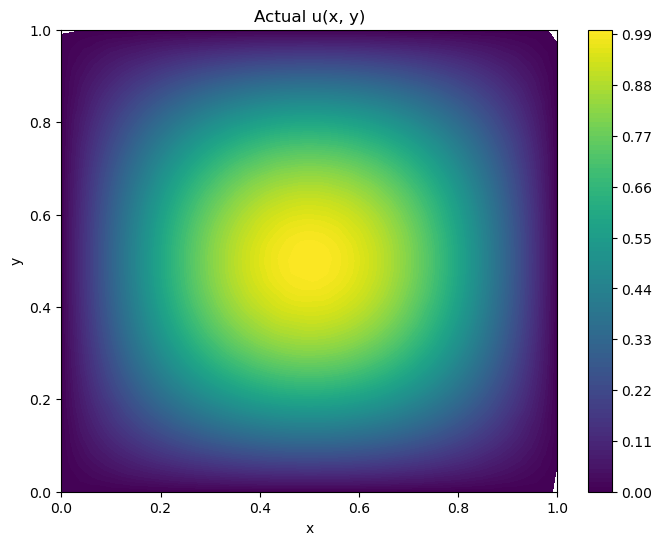

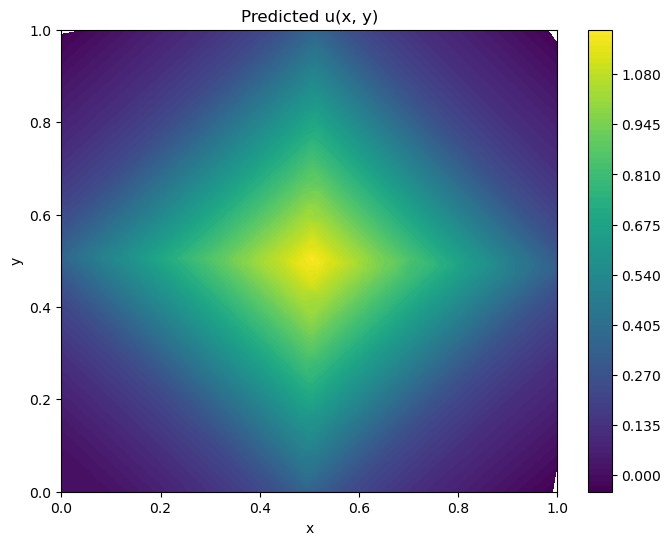

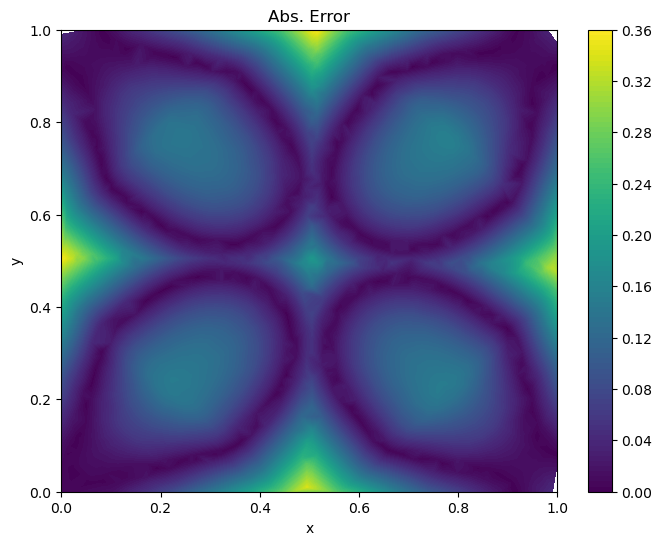

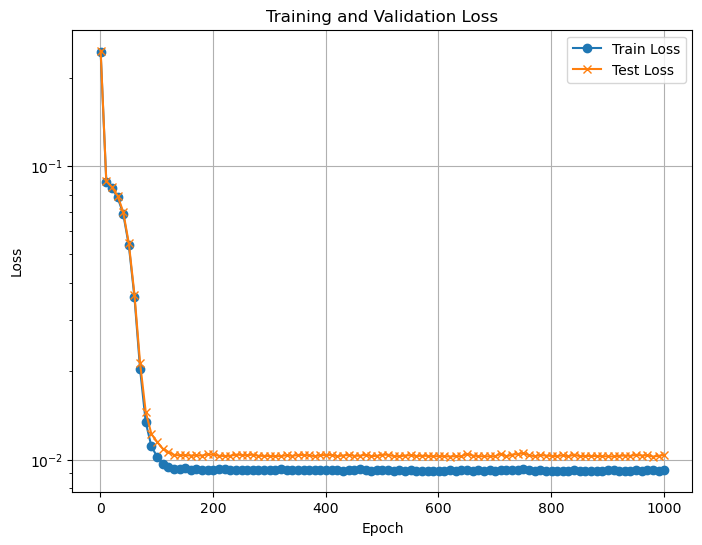

In [14]:
# Visualization
def visualization_2D(x, y, u, title):
    plt.figure(figsize=(8, 6))
    plt.tricontourf(x, y, u, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

visualization_2D(x_test[0,:], x_test[1,:], y_test[0,:], title= "Actual u(x, y)")
visualization_2D(x_test[0,:], x_test[1,:], y_pred[0,:], title="Predicted u(x, y)")

abs_error = np.abs(y_pred[0,:] - y_test[0,:])
visualization_2D(x_test[0,:], x_test[1,:], abs_error, title= "Abs. Error")

# Error Curve
def plot_training_history(record):
    epochs = record.get("epoch", [])
    train_loss = record.get("train_loss", [])
    test_loss = record.get("test_loss", [])

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(record)

In the stable phase (`Epoch 201` → `Epoch 1001`), the training loss and validation loss for the model using the ReLU activation function exhibit minimal differences, indicating no significant overfitting. The predicted solution closely aligns with the analytical solution of the Poisson equation. In the absolute error distribution, the errors are primarily concentrated near the four corners and boundaries of the domain, with a maximum error of approximately `0.36`. In contrast, the errors in the central region are minimal (close to `0`), demonstrating the model's high prediction accuracy in the interior region.

**tanh**

In [15]:
# Data generation for the Poisson equation
def generate_data(num_points=99):
    def analytical_solution(x, y):
        # Poisson equation analytical solution
        sol = np.sin(np.pi * x) * np.sin(np.pi * y)
        sol[(x == 1) | (y == 1)] = 0
        return sol
    x = np.linspace(0, 1, num_points)
    y = np.linspace(0, 1, num_points)
    X, Y = np.meshgrid(x, y)
    u = analytical_solution(X, Y)
    return np.c_[X.ravel(), Y.ravel()], u.ravel()    

# Initialize data
input_data, output_data = generate_data(num_points=100)
sample_num = input_data.shape[0]
permute_idx = np.random.permutation(sample_num)
input_data = input_data.T[:,permute_idx]
output_data = output_data[None,:][:, permute_idx]

# Testing code
nn = FeedforwardNeuralNetwork([2, 32, 32, 1], activation_type="tanh")
split_ratio = 0.7
train_num = int(sample_num * split_ratio)
x_train, x_test = input_data[:, :train_num], input_data[:, train_num:]
y_train, y_test = output_data[:, :train_num], output_data[:, train_num:]

# Train the network
record = nn.train(x_train, y_train, epochs=1001, learning_rate=0.0001, batch_size=64, opt_type="adam", x_val=x_test, y_val=y_test)

# Test error
activations, _ = nn.feedforward(x_train)
y_pred = activations[-1]
test_loss = nn.compute_cost(y_pred, y_train)

# Validate the network
activations, _ = nn.feedforward(x_test)
y_pred = activations[-1]
val_loss = nn.compute_cost(y_pred, y_test)

print(test_loss, val_loss)

(FNN) Epoch 1: Train Loss = 0.244125, Test Loss = 0.247137
(FNN) Epoch 101: Train Loss = 0.087044, Test Loss = 0.087917
(FNN) Epoch 201: Train Loss = 0.087028, Test Loss = 0.087937
(FNN) Epoch 301: Train Loss = 0.087027, Test Loss = 0.087917
(FNN) Epoch 401: Train Loss = 0.087030, Test Loss = 0.087944
(FNN) Epoch 501: Train Loss = 0.087024, Test Loss = 0.087918
(FNN) Epoch 601: Train Loss = 0.087039, Test Loss = 0.087914
(FNN) Epoch 701: Train Loss = 0.087022, Test Loss = 0.087914
(FNN) Epoch 801: Train Loss = 0.087030, Test Loss = 0.087949
(FNN) Epoch 901: Train Loss = 0.087031, Test Loss = 0.087952
(FNN) Epoch 1001: Train Loss = 0.087008, Test Loss = 0.087911
0.08701618634256644 0.08789686764175479


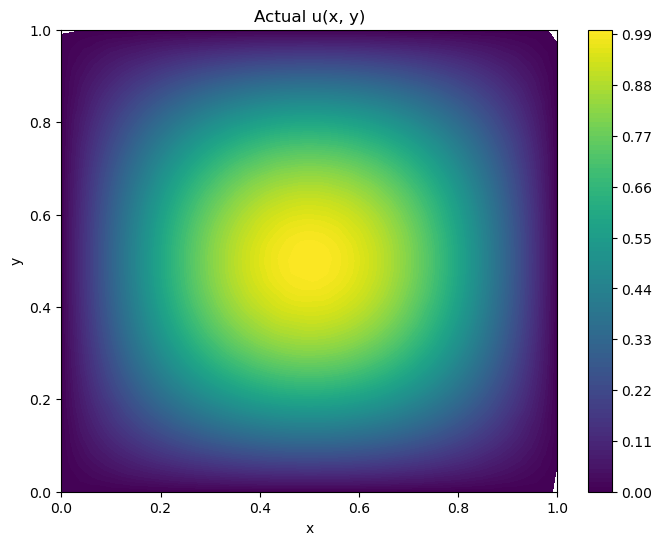

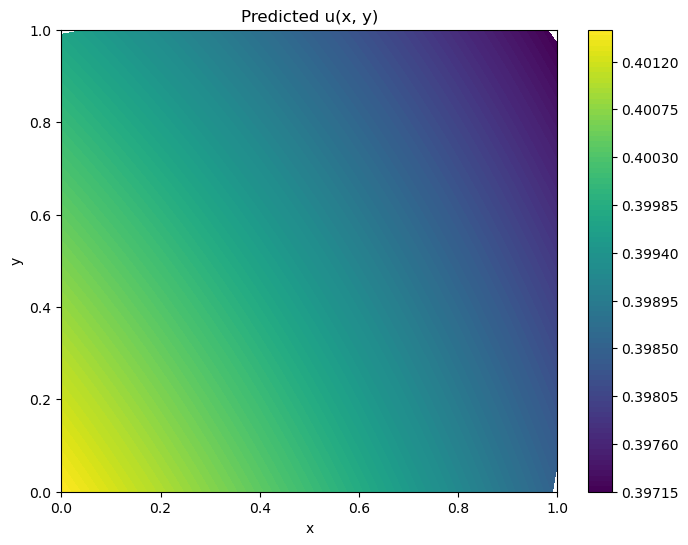

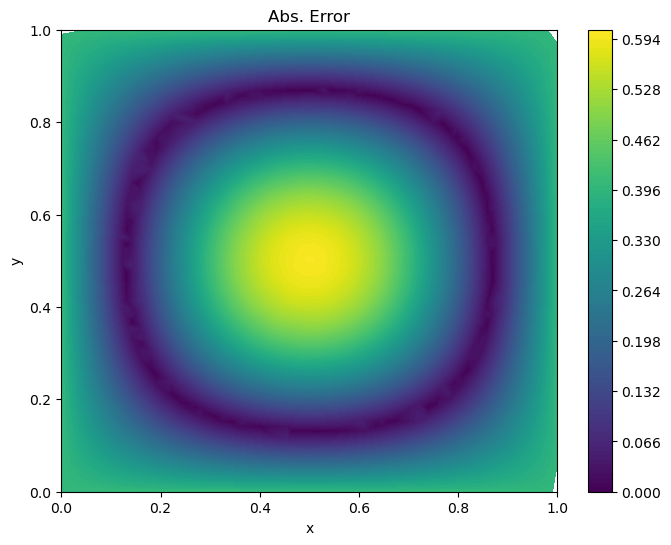

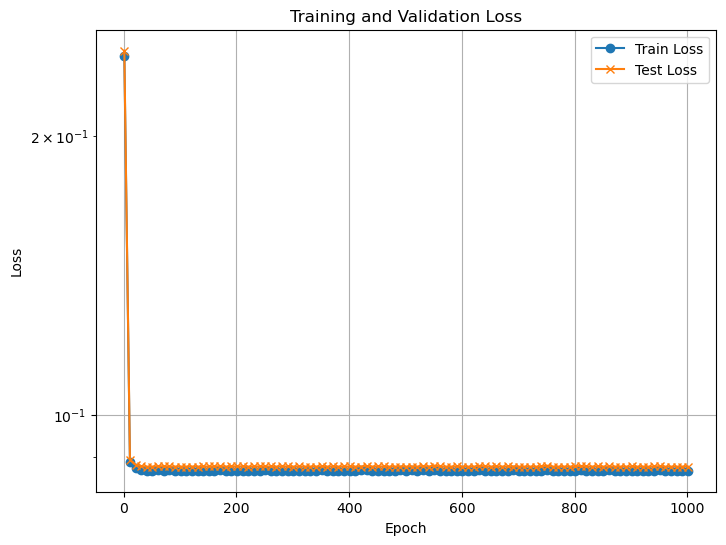

In [17]:
# Visualization
def visualization_2D(x, y, u, title):
    plt.figure(figsize=(8, 6))
    plt.tricontourf(x, y, u, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

visualization_2D(x_test[0,:], x_test[1,:], y_test[0,:], title= "Actual u(x, y)")
visualization_2D(x_test[0,:], x_test[1,:], y_pred[0,:], title="Predicted u(x, y)")

abs_error = np.abs(y_pred[0,:] - y_test[0,:])
visualization_2D(x_test[0,:], x_test[1,:], abs_error, title= "Abs. Error")

# Error Curve
def plot_training_history(record):
    epochs = record.get("epoch", [])
    train_loss = record.get("train_loss", [])
    test_loss = record.get("test_loss", [])

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(record)

The training and validation losses converge quickly without overfitting. However, compared to ReLU, the loss with tanh is significantly higher (`0.087` vs `0.010`). This indicates that the tanh activation function is less effective for solving this problem, likely due to gradient saturation near `−1` and `1`, which restricts the learning process.

**sigmoid**

In [18]:
# Data generation for the Poisson equation
def generate_data(num_points=99):
    def analytical_solution(x, y):
        # Poisson equation analytical solution
        sol = np.sin(np.pi * x) * np.sin(np.pi * y)
        sol[(x == 1) | (y == 1)] = 0
        return sol
    x = np.linspace(0, 1, num_points)
    y = np.linspace(0, 1, num_points)
    X, Y = np.meshgrid(x, y)
    u = analytical_solution(X, Y)
    return np.c_[X.ravel(), Y.ravel()], u.ravel()    

# Initialize data
input_data, output_data = generate_data(num_points=100)
sample_num = input_data.shape[0]
permute_idx = np.random.permutation(sample_num)
input_data = input_data.T[:,permute_idx]
output_data = output_data[None,:][:, permute_idx]

# Testing code
nn = FeedforwardNeuralNetwork([2, 32, 32, 1], activation_type="sigmoid")
split_ratio = 0.7
train_num = int(sample_num * split_ratio)
x_train, x_test = input_data[:, :train_num], input_data[:, train_num:]
y_train, y_test = output_data[:, :train_num], output_data[:, train_num:]

# Train the network
record = nn.train(x_train, y_train, epochs=1001, learning_rate=0.0001, batch_size=64, opt_type="adam", x_val=x_test, y_val=y_test)

# Test error
activations, _ = nn.feedforward(x_train)
y_pred = activations[-1]
test_loss = nn.compute_cost(y_pred, y_train)

# Validate the network
activations, _ = nn.feedforward(x_test)
y_pred = activations[-1]
val_loss = nn.compute_cost(y_pred, y_test)

print(test_loss, val_loss)

(FNN) Epoch 1: Train Loss = 0.249643, Test Loss = 0.252692
(FNN) Epoch 101: Train Loss = 0.087045, Test Loss = 0.087911
(FNN) Epoch 201: Train Loss = 0.087033, Test Loss = 0.087932
(FNN) Epoch 301: Train Loss = 0.087033, Test Loss = 0.087911
(FNN) Epoch 401: Train Loss = 0.087037, Test Loss = 0.087945
(FNN) Epoch 501: Train Loss = 0.087030, Test Loss = 0.087914
(FNN) Epoch 601: Train Loss = 0.087047, Test Loss = 0.087916
(FNN) Epoch 701: Train Loss = 0.087028, Test Loss = 0.087916
(FNN) Epoch 801: Train Loss = 0.087041, Test Loss = 0.087953
(FNN) Epoch 901: Train Loss = 0.087042, Test Loss = 0.087955
(FNN) Epoch 1001: Train Loss = 0.087028, Test Loss = 0.087927
0.0870375823598885 0.08791421430736644


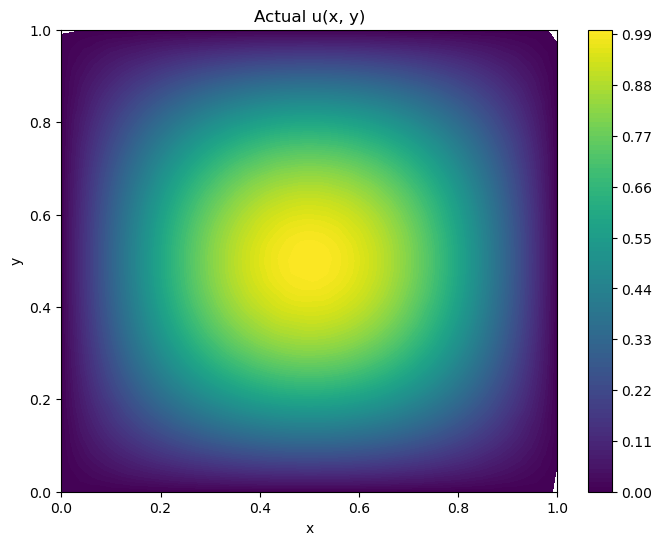

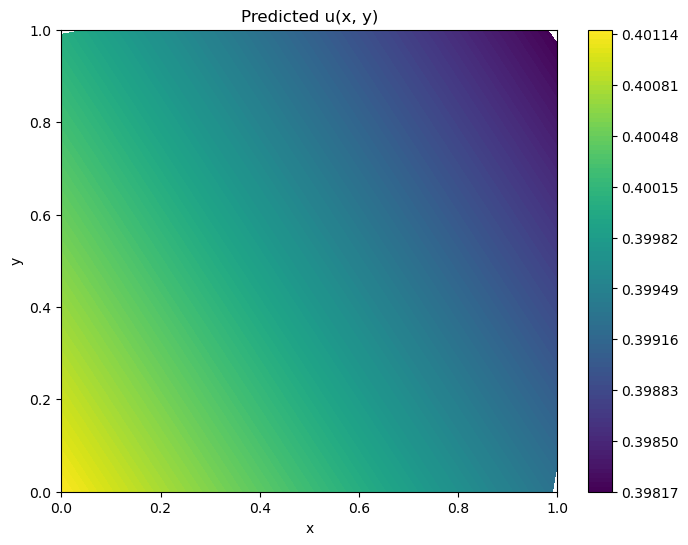

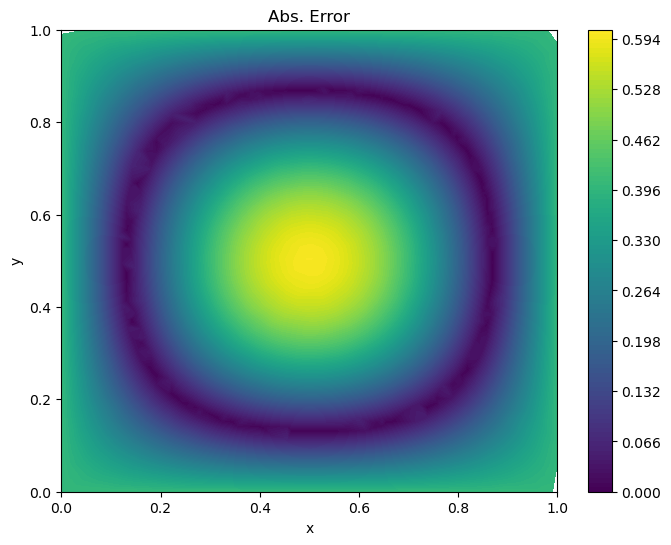

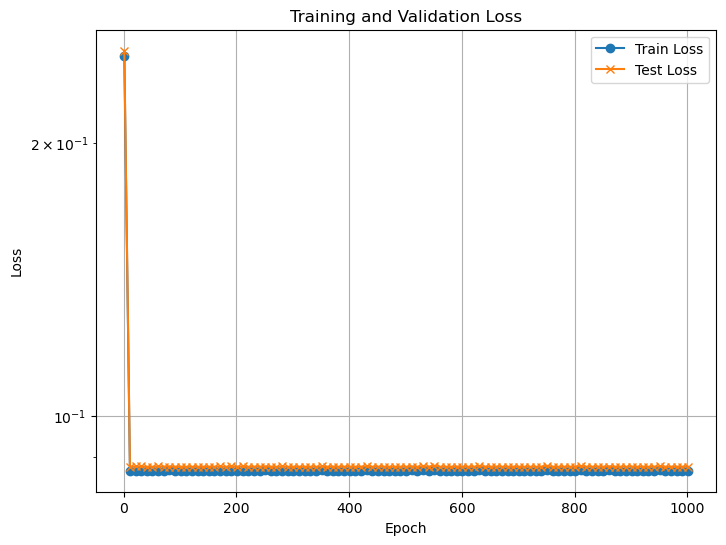

In [19]:
# Visualization
def visualization_2D(x, y, u, title):
    plt.figure(figsize=(8, 6))
    plt.tricontourf(x, y, u, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

visualization_2D(x_test[0,:], x_test[1,:], y_test[0,:], title= "Actual u(x, y)")
visualization_2D(x_test[0,:], x_test[1,:], y_pred[0,:], title="Predicted u(x, y)")

abs_error = np.abs(y_pred[0,:] - y_test[0,:])
visualization_2D(x_test[0,:], x_test[1,:], abs_error, title= "Abs. Error")

# In[] Error Curve
def plot_training_history(record):
    epochs = record.get("epoch", [])
    train_loss = record.get("train_loss", [])
    test_loss = record.get("test_loss", [])

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss, label='Test Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(record)

Similar to tanh, the loss with sigmoid is higher than that of ReLU (0.087 vs 0.010). The sigmoid activation function suffers from gradient saturation near 0 and 1. While both sigmoid and tanh share similar limitations, tanh performs slightly better due to its output range of (−1,1). Although using the sigmoid activation function helps avoid overfitting, its gradient saturation and restricted output range limit the overall accuracy of the model.

In the second approach, the search space includes key hyperparameters such as network architecture, activation function, learning rate, and batch size. 

   - The network architectures range from shallow to deep (`[2, 128, 64, 32, 1]`, `[2, 32, 32, 16, 16, 1]`,`[2, 32, 32, 16, 16, 16, 1]`).

   - The activation functions ReLU, Tanh, and Sigmoid were chosen to test different types of nonlinear mappings. 

   - Learning rates of `0.001` and `0.0005` were used. 

   - Batch sizes of `32` and `64` were selected to trade off between training efficiency. 

   - `3-fold` cross-validation was applied to evaluate the models while keeping the computational cost manageable.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Split the data into folds manually for cross-validation
def split_folds(x, y, num_folds):
    fold_size = x.shape[1] // num_folds
    folds = []
    for i in range(num_folds):
        val_indices = list(range(i * fold_size, (i + 1) * fold_size))
        train_indices = list(set(range(x.shape[1])) - set(val_indices))
        x_train, x_val = x[:, train_indices], x[:, val_indices]
        y_train, y_val = y[:, train_indices], y[:, val_indices]
        folds.append((x_train, y_train, x_val, y_val))
    return folds

# Define the hyperparameter search space
architectures = [
    [2, 16, 16, 1],
    [2, 128, 64, 32, 1],
    [2, 32, 32, 16, 16, 16, 1]
]
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
activation_functions = ["relu", "tanh", "sigmoid"]
num_folds = 3

# Generate synthetic data for testing
def generate_data(num_points=10000):
    x = np.linspace(0, 1, int(np.sqrt(num_points)))
    y = np.linspace(0, 1, int(np.sqrt(num_points)))
    X, Y = np.meshgrid(x, y)
    Z = np.sin(np.pi * X) * np.sin(np.pi * Y)  # Analytical solution
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    Z_flat = Z.flatten()
    inputs = np.vstack((X_flat, Y_flat))  # Shape: (2, num_points)
    outputs = Z_flat.reshape(1, -1)  # Shape: (1, num_points)
    return inputs, outputs

# Evaluate a single configuration with early stopping
def evaluate_model(architecture, activation, learning_rate, batch_size, folds, patience=15):
    validation_losses = []

    for x_train, y_train, x_val, y_val in folds:
        # Initialize the network
        nn = FeedforwardNeuralNetwork(architecture, activation_type=activation)

        best_val_loss = float('inf')
        no_improvement_epochs = 0

        # Training loop with early stopping
        for epoch in range(100):  # Max number of epochs
            train_loss = nn.train(x_train, y_train, epochs=1, learning_rate=learning_rate, batch_size=batch_size)

            # Validate the network
            predictions, _ = nn.feedforward(x_val)
            val_loss = nn.compute_cost(predictions[-1], y_val)

            # Check for improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1

            # Early stopping condition
            if no_improvement_epochs >= patience:
                break

        # Save the best validation loss
        validation_losses.append(best_val_loss)

    return np.mean(validation_losses)

# Perform grid search
results = []

# Initialize the data
x_data, y_data = generate_data()
folds = split_folds(x_data, y_data, num_folds)

print("Starting grid search with early stopping...")

for architecture in architectures:
    for activation in activation_functions:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                avg_loss = evaluate_model(architecture, activation, learning_rate, batch_size, folds, patience=5)
                results.append({
                    "Architecture": str(architecture),
                    "Activation": activation,
                    "Learning Rate": learning_rate,
                    "Batch Size": batch_size,
                    "Validation Loss": avg_loss
                })
                print(f"Architecture: {architecture}, Activation: {activation}, Learning Rate: {learning_rate}, "
                      f"Batch Size: {batch_size}, Validation Loss: {avg_loss:.6f}")

# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

# Find the best parameters
best_row = results_df.loc[results_df["Validation Loss"].idxmin()]
print("\nBest Parameters:")
print(best_row)


Starting grid search with early stopping...
Architecture: [2, 16, 16, 1], Activation: relu, Learning Rate: 0.001, Batch Size: 32, Validation Loss: 0.098414
Architecture: [2, 16, 16, 1], Activation: relu, Learning Rate: 0.001, Batch Size: 64, Validation Loss: 0.098013
Architecture: [2, 16, 16, 1], Activation: relu, Learning Rate: 0.0005, Batch Size: 32, Validation Loss: 0.097973
Architecture: [2, 16, 16, 1], Activation: relu, Learning Rate: 0.0005, Batch Size: 64, Validation Loss: 0.098034
Architecture: [2, 16, 16, 1], Activation: tanh, Learning Rate: 0.001, Batch Size: 32, Validation Loss: 0.098422
Architecture: [2, 16, 16, 1], Activation: tanh, Learning Rate: 0.001, Batch Size: 64, Validation Loss: 0.098014
Architecture: [2, 16, 16, 1], Activation: tanh, Learning Rate: 0.0005, Batch Size: 32, Validation Loss: 0.097973
Architecture: [2, 16, 16, 1], Activation: tanh, Learning Rate: 0.0005, Batch Size: 64, Validation Loss: 0.098035
Architecture: [2, 16, 16, 1], Activation: sigmoid, Learn

We initially set the architecture range to `[2, 16, 16, 1]`, `[2, 32, 32, 1]`, and `[2, 16, 16, 16, 1]`. We tested learning rates of `0.01` and `0.1` with a patience value of `5`. Smaller batch sizes (e.g., `64`) performed better than larger ones (e.g., `128`), likely because they captured finer gradients. After introducing early stopping, it was often triggered between the `6th` and `15th` epochs. This suggests the following issues:

    -High learning rate: A high learning rate may cause the model to converge too quickly, preventing further improvement.
    -Insufficient network capacity: The model may not be complex enough to extract meaningful features from the data.
    
To address these problems, we set the learning rate to `[0.001, 0.0005]`, adjusted the batch size to `[32, 64]`, and increased the patience value to 15 to give the model more time for optimization and reduce premature stopping.
    
Based on this search space, the best architecture was found to be `[2, 32, 32, 16, 16, 16, 1]`, showing that the network does not need to be overly deep or wide to learn effectively. The optimal learning rate was `0.0005`, as higher rates (e.g., `0.001`) led to worse validation losses in some cases. The best validation loss was `0.097861`, and the results were concentrated within a narrow range indicating stable model performance.

**(c)**

FDM is given as follow：

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

class PoissonSolver2D:
    def __init__(self, nx, ny, lx, ly):
        """
        Initialize the Poisson solver with grid size and domain dimensions.
        
        Parameters:
        nx (int): Number of grid points in the x-direction.
        ny (int): Number of grid points in the y-direction.
        lx (float): Length of the domain in the x-direction.
        ly (float): Length of the domain in the y-direction.
        """
        self.nx = nx
        self.ny = ny
        self.lx = lx
        self.ly = ly
        self.dx = lx / (nx - 1)
        self.dy = ly / (ny - 1)
        self.u = np.zeros((ny, nx))  # Solution array
        self.f = np.zeros((ny, nx))  # Source term array

    def set_boundary_conditions(self, boundary_func):
        """
        Set the boundary conditions using a provided function.
        
        Parameters:
        boundary_func (function): Function that takes (x, y) and returns the boundary value.
        """
        for i in range(self.nx):
            self.u[0, i] = boundary_func(i * self.dx, 0)  # Bottom boundary
            self.u[-1, i] = boundary_func(i * self.dx, self.ly)  # Top boundary
        for j in range(self.ny):
            self.u[j, 0] = boundary_func(0, j * self.dy)  # Left boundary
            self.u[j, -1] = boundary_func(self.lx, j * self.dy)  # Right boundary

    def set_source_term(self, source_func):
        """
        Set the source term using a provided function.
        
        Parameters:
        source_func (function): Function that takes (x, y) and returns the source term value.
        """
        for j in range(1, self.ny - 1):
            for i in range(1, self.nx - 1):
                self.f[j, i] = source_func(i * self.dx, j * self.dy)

    def setup_linear_system(self):
        """
        Set up the linear system for the Poisson equation.
        
        Returns:
        A (scipy.sparse.lil_matrix): Sparse matrix representing the linear system.
        b (numpy.ndarray): Right-hand side vector.
        """
        n = self.nx * self.ny
        A = lil_matrix((n, n))
        b = np.zeros(n)

        for j in range(self.ny):
            for i in range(self.nx):
                idx = j * self.nx + i
                if i == 0 or i == self.nx - 1 or j == 0 or j == self.ny - 1:
                    A[idx, idx] = 1
                    b[idx] = self.u[j, i]
                else:
                    A[idx, idx] = -4
                    A[idx, idx - 1] = 1
                    A[idx, idx + 1] = 1
                    A[idx, idx - self.nx] = 1
                    A[idx, idx + self.nx] = 1
                    b[idx] = - (self.dx*self.dy) * self.f[j, i]

        return A, b

    def solve(self):
        """
        Solve the Poisson equation using a sparse direct solver.
        """
        A, b = self.setup_linear_system()
        u_flat = spsolve(A.tocsr(), b)
        self.u = u_flat.reshape((self.ny, self.nx))

    def get_solution(self):
        """
        Get the solution of the Poisson equation.
        
        Returns:
        numpy.ndarray: Solution array.
        """
        return self.u
    
    def get_meshgrid(self):
        """
        Get the meshgrid for the domain.
        
        Returns:
        numpy.ndarray: Meshgrid for the domain.
        """
        x = np.linspace(0, self.lx, self.nx)
        y = np.linspace(0, self.ly, self.ny)
        return np.meshgrid(x, y)
    
    def plot_solution(self):
        """
        Plot the solution of the Poisson equation.
        """
        plt.imshow(self.u, origin='lower', extent=(0, self.lx, 0, self.ly))
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Poisson equation solution')
        plt.show()

Compare FNN to FDM:

(FNN) Epoch 1: Train Loss = 0.228356, Test Loss = 0.284009
(FNN) Epoch 501: Train Loss = 0.000217, Test Loss = 0.000515
Mean Squared Error (FNN vs FDM): 0.000108


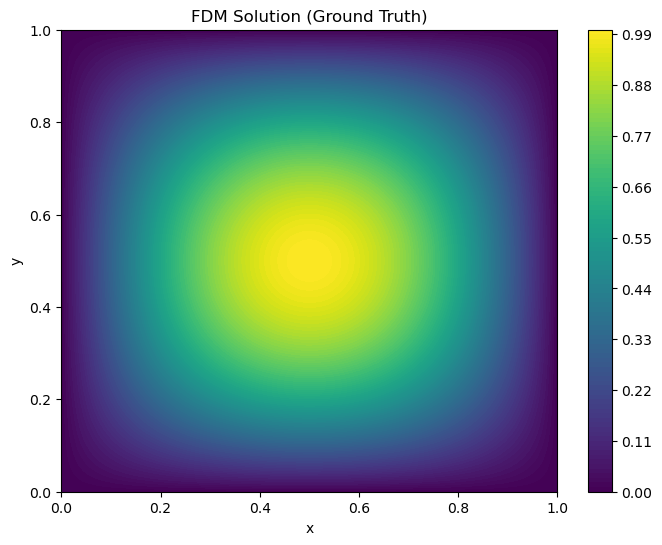

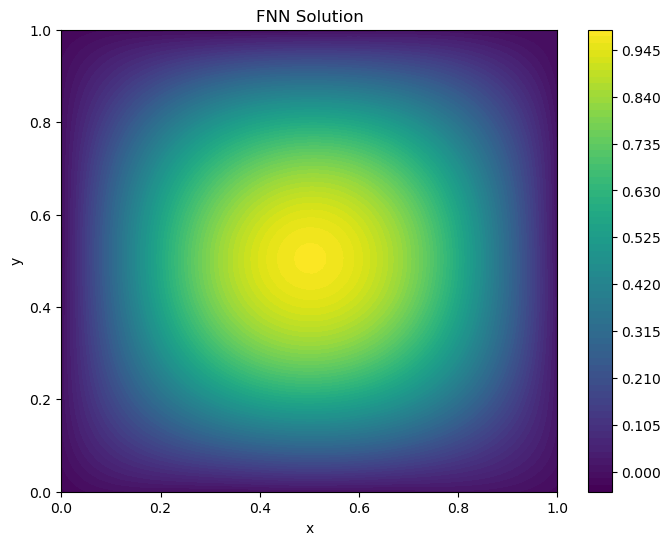

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

# Visualization function
def visualization_2D(x, y, u, title):
    plt.figure(figsize=(8, 6))
    plt.tricontourf(x, y, u, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Solve the 2D Poisson equation using FDM 
def boundary_func(x, y):
    return 0.0

def source_func(x, y):
    return 2.0 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

# Initialize and solve the Poisson equation using FDM
fdm_solver = PoissonSolver2D(nx=100, ny=100, lx=1.0, ly=1.0)
fdm_solver.set_boundary_conditions(boundary_func)
fdm_solver.set_source_term(source_func)
fdm_solver.solve()

# Get meshgrid coordinates and FDM solution
x_mesh, y_mesh = fdm_solver.get_meshgrid()
fdm_solution = fdm_solver.get_solution()
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
fdm_solution_flat = fdm_solution.flatten()

# Training data for FNN
train_x = np.vstack((x_flat, y_flat))  # Inputs: Grid points (x, y)
train_y = fdm_solution_flat.reshape(1, -1)  # Outputs: FDM solution values

# Data augmentation
noise_level = 0.01
train_x_aug = train_x + noise_level * np.random.randn(*train_x.shape)

train_x_combined = np.hstack((train_x, train_x_aug))
train_y_combined = np.hstack((train_y, train_y))  # Duplicate outputs for augmented inputs

# Split data into training and validation sets
split_index = int(0.7 * train_x_combined.shape[1])
x_train, x_val = train_x_combined[:, :split_index], train_x_combined[:, split_index:]
y_train, y_val = train_y_combined[:, :split_index], train_y_combined[:, split_index:]

# Train the FNN
layer_sizes = [2, 20, 20, 1]  
fnn = FeedforwardNeuralNetwork(layer_sizes, activation_type="tanh")

# Train the model
record = fnn.train(x_train, y_train, epochs=1000, learning_rate=0.01, batch_size=64,
                   opt_type="adam", x_val=x_val, y_val=y_val, interval=50)

# Predict the solution at grid points
fnn_predictions = fnn.feedforward(train_x)[0][-1]
fnn_solution = fnn_predictions.reshape(x_mesh.shape)

# Compute the error
mse_fnn = mean_squared_error(fdm_solution_flat, fnn_predictions.flatten())
print(f"Mean Squared Error (FNN vs FDM): {mse_fnn:.6f}")

# Visualize the results

visualization_2D(x_flat, y_flat, fdm_solution_flat, "FDM Solution (Ground Truth)")

visualization_2D(x_flat, y_flat, fnn_predictions.flatten(), "FNN Solution")


We increased the grid resolution from `(50 × 50)` to `(100 × 100)`, simplified the network to `[2,20,20,1]`, and added noise to the training data to reduce overfitting. The resulting MSE shows that the model predictions match the FDM solution well. The test error is slightly higher than the training error, but the difference is small, indicating minimal overfitting.

# Part 2 – Deep Operator Network Architecture (DeepONet)

**(a)**

We aim to implement the DeepONet (Deep Operator Network) architecture to approximate the solution u(x,y) for the Poisson equation with fixed b and varying a. 

   - Branch Network: Takes the parameter 𝑎 as input and outputs a feature representation.
   - Trunk Network: Takes spatial coordinates (𝑥,𝑦) as input and outputs another feature representation.
   - Final Output: The solution 𝑢(𝑥,𝑦) is obtained as the dot product of the branch and trunk outputs:

$$
\text{DeepONet}(a, x, y) = \text{BranchNet}(a)^T \cdot \text{TrunkNet}(x, y)
$$


**DeepONet Class**

In [ ]:
from fnn import FeedforwardNeuralNetwork
import numpy as np

class DeepONet:
    def __init__(self, branch_layer_sizes, trunk_layer_sizes, activation_type="relu"):
        self.branch_net = FeedforwardNeuralNetwork(branch_layer_sizes, activation_type)
        self.trunk_net = FeedforwardNeuralNetwork(trunk_layer_sizes, activation_type)

    def infer(self, x_branch, x_trunk):
        branch_output, _ = self.branch_net.feedforward(x_branch)
        trunk_output, _ = self.trunk_net.feedforward(x_trunk)
        return branch_output[-1].T @ trunk_output[-1]

**Training Process**

In [ ]:
# Generate training data
a_values = np.random.uniform(-1, 1, (1, 100))  # Parameter a
xy_points = np.random.uniform(0, 1, (2, 1000))  # Spatial coordinates (x, y)
u_true = np.sin(np.pi * xy_points[0]) * np.sin(np.pi * xy_points[1]) * a_values.T

# Initialize the network
branch_sizes = [1, 20, 20, 10]
trunk_sizes = [2, 20, 20, 10]
deepONet = DeepONet(branch_sizes, trunk_sizes)

# Train the network
epochs = 1000
learning_rate = 0.01

for epoch in range(epochs):
    # Forward pass
    y_pred = deepONet.infer(a_values, xy_points)
    loss = np.mean((y_pred - u_true) ** 2)

    # Backpropagation and parameter updates
    branch_grad, trunk_grad = deepONet.loss_gradient(deepONet.branch_net, deepONet.trunk_net, u_true)
    deepONet.branch_net.update_parameters(branch_grad, learning_rate)
    deepONet.trunk_net.update_parameters(trunk_grad, learning_rate)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.6f}")

**Complete Python implementation of the DeepONet:**

In [2]:
import numpy as np


class DeepONet:
    def __init__(self, branch_layer_sizes, trunk_layer_sizes, activation_type):
        self.branch_net = FeedforwardNeuralNetwork(branch_layer_sizes,activation_type)
        self.trunk_net = FeedforwardNeuralNetwork(trunk_layer_sizes, activation_type)

        # Ensure the output dimensions of the branch and trunk nets match
        assert branch_layer_sizes[-1] == trunk_layer_sizes[-1], "Output dimensions of branch and trunk nets must match"

    def feedforward(self, x_branch, x_trunk):
        a_branch, z_branch = self.branch_net.feedforward(x_branch) # output shape = {D, func_num}
        a_trunk, z_trunk = self.trunk_net.feedforward(x_trunk)   # output shape = {D, query_points}

        return a_branch, z_branch, a_trunk, z_trunk

    def infer(self, x_branch, x_trunk):
        a_branch, _, a_trunk, _ = self.feedforward(x_branch, x_trunk)
        return a_branch[-1].T @ a_trunk[-1]

    def compute_cost(self, y_branch, y_trunk, u_true):
        return 0.5 * np.mean((y_branch.T @ y_trunk - u_true) ** 2)

    def loss_gradient(self, y_branch, y_trunk, u_true):

        batch_size = y_branch.shape[1]
        query_points = y_trunk.shape[1]
        total_num = batch_size * query_points

        branch_grad = y_trunk @ (y_branch.T @ y_trunk - u_true).T / total_num        # shape = {D, func_num}
        trunk_grad =  y_branch @ (y_branch.T @ y_trunk - u_true)  / total_num       # shape = {D, query_points}

        return branch_grad, trunk_grad


    def backpropagate(self, x_branch, x_trunk, u_true):

        a_branch, z_branch, a_trunk, z_trunk = self.feedforward(x_branch, x_trunk)
        branch_grad, trunk_grad = self.loss_gradient(a_branch[-1], a_trunk[-1], u_true)

        branch_w_grad, branch_b_grad = self.branch_net.backpropagate(z_branch, a_branch, branch_grad)
        trunk_w_grad, trunk_b_grad = self.trunk_net.backpropagate(z_trunk, a_trunk, trunk_grad)

        return branch_w_grad, branch_b_grad, trunk_w_grad, trunk_b_grad

    def update_parameters(self, nabla_w_branch, nabla_b_branch, nabla_w_trunk, nabla_b_trunk, learning_rate, opt_type = "sgd"):
        self.branch_net.update_parameters(nabla_w_branch, nabla_b_branch, learning_rate, opt_type)
        self.trunk_net.update_parameters(nabla_w_trunk, nabla_b_trunk, learning_rate, opt_type)

    def train(self, x_branch, x_trunk, u_train, epochs, learning_rate, batch_size,
              opt_type = "sgd", x_val=None, u_val=None, interval = 10):

        record = None
        np.random.seed(42)
        function_num = x_branch.shape[1]
        query_points = x_trunk.shape[1]

        if x_val is not None and u_val is not None:
            val_branch, val_trunk = x_val
            record = {
                "epoch": [],
                "train_loss": [],
                "test_loss": []
            }

        for iter in range(epochs):
            branch_idx = np.random.permutation(function_num)
            trunk_idx = np.random.permutation(query_points)

            x_branch, x_trunk = x_branch[:, branch_idx], x_trunk[:, trunk_idx]

            u_train = u_train[np.ix_(branch_idx, trunk_idx)] if function_num > 1 else u_train[:, trunk_idx]

            # record the training and testing/validation loss during model training
            if iter % interval == 0 and record is not None:

                record["epoch"].append(iter + 1)

                y_branch, _, y_trunk, _ = self.feedforward(x_branch, x_trunk)
                train_loss = self.compute_cost(y_branch[-1], y_trunk[-1], u_train)
                record["train_loss"].append(train_loss)

                y_branch, _, y_trunk, _ = self.feedforward(val_branch, val_trunk)
                val_loss = self.compute_cost(y_branch[-1], y_trunk[-1], u_val)
                record["test_loss"].append(val_loss)

                if iter % (interval * 10) == 0:
                    print(f"(DeepONET) Epoch {iter + 1}: Train Loss = {train_loss:.6f}, Test Loss = {val_loss:.6f}")

            # Mini-batch training
            # -( n // -d) is equivalent to ceil(n/d) in Python
            for i in range(-(function_num // -batch_size)):
                if (i + 1) * batch_size >= function_num:
                    x_batch_branch = x_branch[:, i * batch_size:]
                    # x_batch_trunk = x_trunk[:, i * batch_size:]
                    u_batch = u_train[i * batch_size:, :]
                else:
                    x_batch_branch = x_branch[:, i * batch_size: (i + 1) * batch_size]
                    # x_batch_trunk = x_trunk[:, i * batch_size: (i + 1) * batch_size]
                    u_batch = u_train[i * batch_size: (i + 1) * batch_size, :]

                # Forward & Backward Propagation
                branch_w_grad, branch_b_grad, trunk_w_grad, trunk_b_grad = self.backpropagate(x_batch_branch, x_trunk, u_batch)
                self.update_parameters(branch_w_grad, branch_b_grad, trunk_w_grad, trunk_b_grad, learning_rate, opt_type)
        return record

**(b)**

The following is the complete test code:

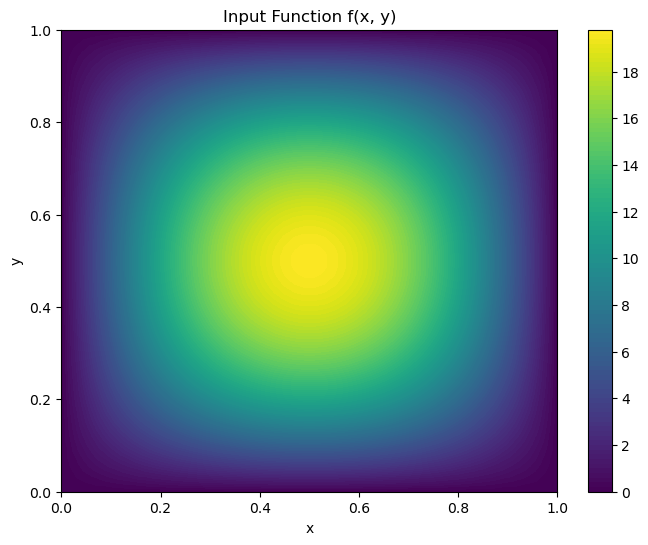

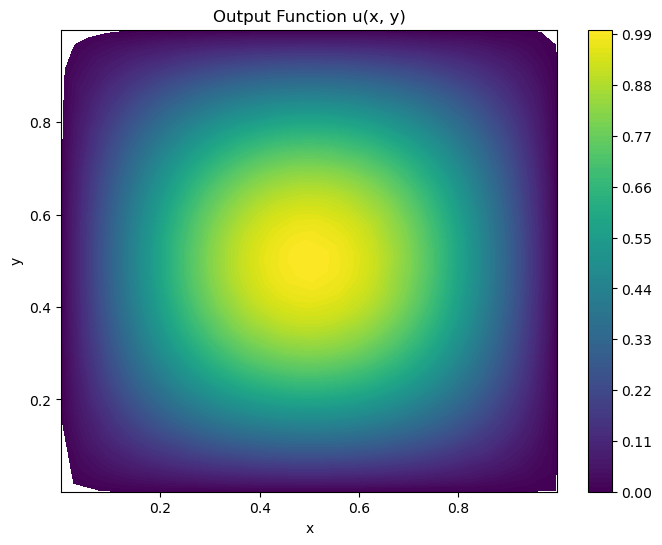

(DeepONET) Epoch 1: Train Loss = 0.041932, Test Loss = 0.051302
(DeepONET) Epoch 101: Train Loss = 0.000179, Test Loss = 0.000236
(DeepONET) Epoch 201: Train Loss = 0.000171, Test Loss = 0.000225
(DeepONET) Epoch 301: Train Loss = 0.000168, Test Loss = 0.000222
(DeepONET) Epoch 401: Train Loss = 0.000166, Test Loss = 0.000220
(DeepONET) Epoch 501: Train Loss = 0.000165, Test Loss = 0.000218
(DeepONET) Epoch 601: Train Loss = 0.000163, Test Loss = 0.000217
(DeepONET) Epoch 701: Train Loss = 0.000161, Test Loss = 0.000217
(DeepONET) Epoch 801: Train Loss = 0.000160, Test Loss = 0.000218
(DeepONET) Epoch 901: Train Loss = 0.000159, Test Loss = 0.000218


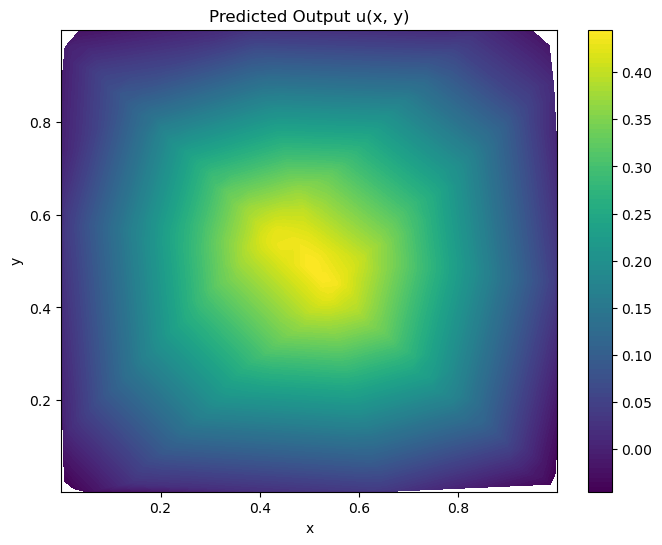

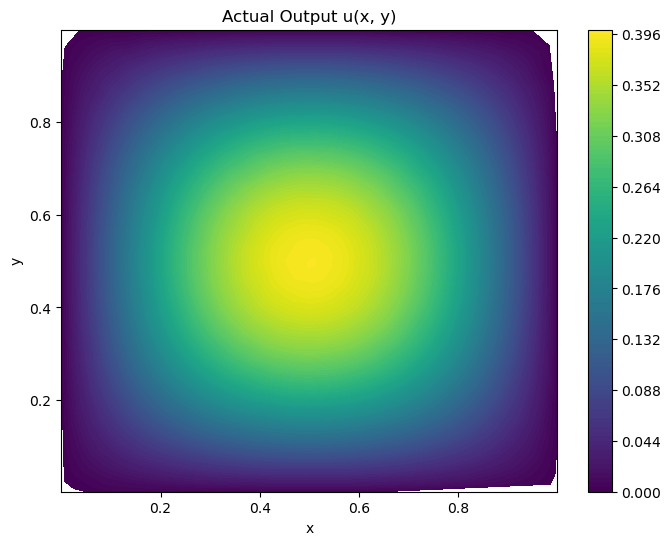

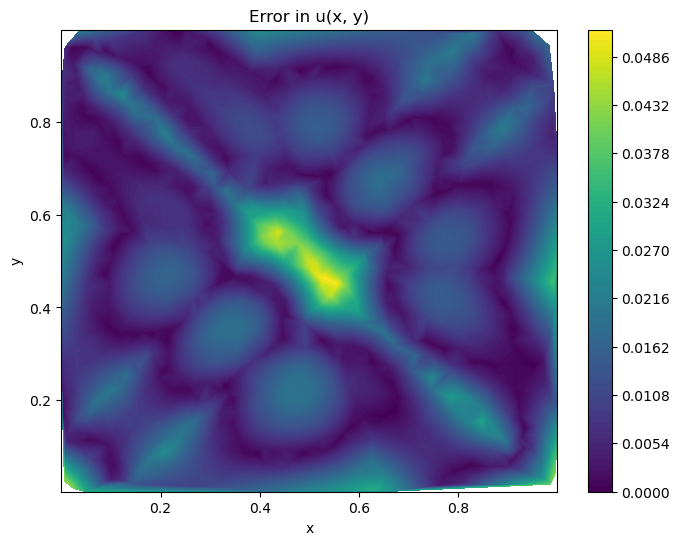

In [6]:
from matplotlib import pyplot as plt
import numpy as np


# Poisson 2D data generation
def generate_deeponet_data(a_list, num_sample_points=50, num_query_points=2000):
    # Generate input sampling points for the Branch network
    input_x = np.linspace(0, 1, num_sample_points)
    input_y = np.linspace(0, 1, num_sample_points)
    input_X, input_Y = np.meshgrid(input_x, input_y)
    branch_points = np.c_[input_X.ravel(), input_Y.ravel()]

    # Generate independent query points for the Trunk network
    trunk_input = np.random.uniform(0, 1, [num_query_points, 2])

    # Generate functions f and corresponding labels u for each parameter a
    branch_input = []
    labels = []

    for a in a_list:
        # f(x, y) = 2 * a * π^2 * sin(πx) * sin(πy), sampled over branch points
        f = 2 * a * (np.pi ** 2) * np.sin(np.pi * branch_points[:, 0]) * np.sin(np.pi * branch_points[:, 1])
        branch_input.append(f)

        # u(x, y) = a * sin(πx) * sin(πy), sampled over trunk input
        u = a * np.sin(np.pi * trunk_input[:, 0]) * np.sin(np.pi * trunk_input[:, 1])
        labels.append(u)

    # Convert to NumPy arrays
    branch_input = np.stack(branch_input, axis=0)  # Shape: (batch_size, num_input_points)
    labels = np.stack(labels, axis=0)             # Shape: (batch_size, num_query_points)

    return branch_input.T, branch_points.T, trunk_input.T, labels


# Data preparation
a_train = np.linspace(-1, 1, 1000)  # Training values for a
a_test = np.array([np.random.uniform(-1, 1) for _ in range(10)])

# Generating data
x_branch_train, branch_points_train, x_trunk_train, u_train = generate_deeponet_data(a_train)
x_branch_test, branch_points_test, x_trunk_test, u_test = generate_deeponet_data(a_test)

# Visualization of generated data
# Visualize f(x, y)
a_list_index = -1
f_values = x_branch_train[:, a_list_index]  # Take the last sample
branch_x, branch_y = branch_points_train[0, :], branch_points_train[1, :]
visualization_2D(branch_x, branch_y, f_values, title=f"Input Function f(x, y)")

# Visualize u(x, y)
u_values_sample = u_train[a_list_index, :]  # Shape: (num_query_points,)
trunk_x, trunk_y = x_trunk_train[0, :], x_trunk_train[1, :]  # Coordinates
visualization_2D(trunk_x, trunk_y, u_values_sample, title=f"Output Function u(x, y)")

# Shuffle training data
sample_num, func_num = x_branch_train.shape
permute_idx = np.random.permutation(func_num)
x_branch_train = x_branch_train[:, permute_idx]
u_train = u_train[permute_idx]

# DeepONet setup
branch_layer_sizes = [sample_num, 32, 64]  # Branch net: takes f(x, y) as input
trunk_layer_sizes = [2,32, 64]  # Trunk net: takes (x, y) as input
deeponet = DeepONet(branch_layer_sizes, trunk_layer_sizes, "relu")

# Train DeepONet
record = deeponet.train(x_branch_train, x_trunk_train, u_train, epochs=1000,
                        learning_rate=0.0001, batch_size=64, opt_type="adam",
                        x_val=(x_branch_test, x_trunk_test), u_val=u_test)

# Test and visualize predictions
u_test_pred = deeponet.infer(x_branch_test, x_trunk_test)
trunk_x, trunk_y = x_trunk_test[0, :], x_trunk_test[1, :]  # Coordinates
visualization_2D(trunk_x, trunk_y, u_test_pred[0], title=f"Predicted Output u(x, y)")
visualization_2D(trunk_x, trunk_y, u_test[0], title=f"Actual Output u(x, y)")
visualization_2D(trunk_x, trunk_y, np.abs(u_test_pred[0] - u_test[0]), title=f"Error in u(x, y)")


**1. Hyperparameter Optimization with Cross-Validation:**

We first set the neural network architecture to `[sample_num, 32, 64]`, the learning rate to `0.0001`, the batch size to `64`. Under this configuration, the ReLU activation function achieved the lowest final loss, with both training and testing losses close to zero (approximately `0.00003`), demonstrating the best performance, followed by sigmoid, and finally tanh.

Keeping all other parameters unchanged, we increased the complexity of the neural network architecture. ReLU continued to perform the best and further improved its accuracy.

Additionally, keeping all other parameters unchanged, we set the learning rate to `0.001`. The final loss results for learning rates of `0.001` and `0.0001` were nearly identical, but a learning rate of `0.001` led to faster convergence.

**2. Validate the Model for Unseen a Values:**

We generate the test set \(a\) values, which are not included in the training set, using the following code:

```python
a_test = np.array([np.random.uniform(-1, 1) for _ in range(10)])
```

The infer function is used to predict the output for these unseen a values:
```python
u_test_pred = deeponet.infer(x_branch_test, x_trunk_test)
```
Finally, the model's performance is evaluated by visualizing the predicted u(x,y), the true values, and the error between them.

**(c)**

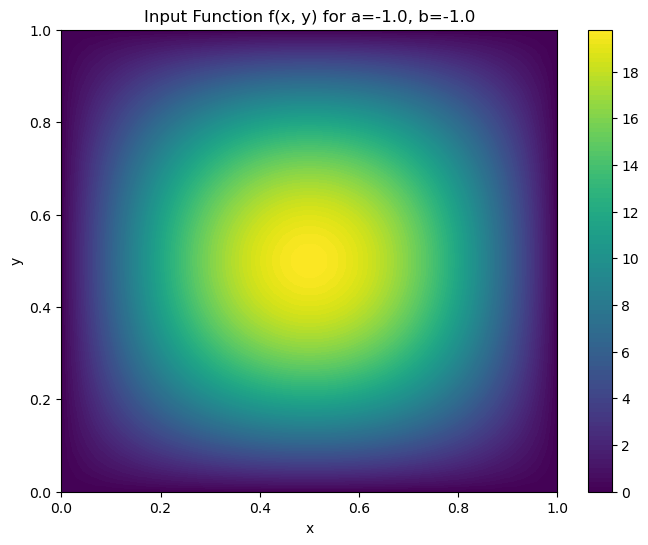

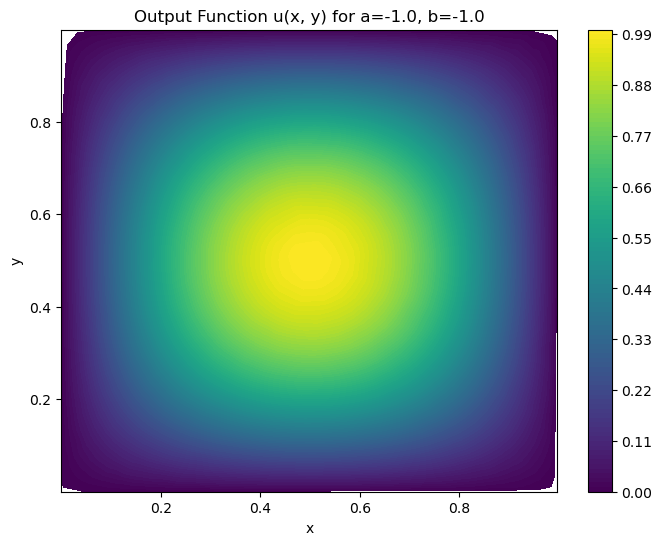

(DeepONET) Epoch 1: Train Loss = 0.014204, Test Loss = 0.008619


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Poisson 2D data generation (considering variations in both a and b)
def generate_deeponet_data(a_list, b_list, num_sample_points=50, num_query_points=2000):


    # Generate Branch network input
    input_x = np.linspace(0, 1, num_sample_points)
    input_y = np.linspace(0, 1, num_sample_points)
    input_X, input_Y = np.meshgrid(input_x, input_y)
    branch_points = np.c_[input_X.ravel(), input_Y.ravel()]

    # Generate Trunk network input
    trunk_input = np.random.uniform(0, 1, [num_query_points, 2])

    # Generate functions f and target u for different combinations of a and b
    branch_input = []
    labels = []

    for a in a_list:
        for b in b_list:
            # f(x, y) = 2 * a * b * π^2 * sin(πx) * sin(πy), sampled at f(x, y)
            f = 2 * a * b * (np.pi ** 2) * np.sin(np.pi * branch_points[:, 0]) * np.sin(np.pi * branch_points[:, 1])
            branch_input.append(f)

            # u(x, y) = a * b * sin(πx) * sin(πy)
            u = a * b * np.sin(np.pi * trunk_input[:, 0]) * np.sin(np.pi * trunk_input[:, 1])
            labels.append(u)

    branch_input = np.stack(branch_input, axis=0)  # Shape: (batch_size, num_input_points)
    labels = np.stack(labels, axis=0)             # Shape: (batch_size, num_query_points)

    return branch_input.T, branch_points.T, trunk_input.T, labels


# Data preparation
a_train = np.linspace(-1, 1, 100)  # Training values for a
b_train = np.linspace(-1, 1, 100)  # Training values for b
a_test = np.array([np.random.uniform(-1, 1) for _ in range(10)])
b_test = np.array([np.random.uniform(-1, 1) for _ in range(10)])

# Generating data
x_branch_train, branch_points_train, x_trunk_train, u_train = generate_deeponet_data(a_train, b_train)
x_branch_test, branch_points_test, x_trunk_test, u_test  = generate_deeponet_data(a_test, b_test)

# Visualize generated data
a_list_index = 0 
b_list_index = 0  

# Visualize f(x, y) for a specific combination of a and b
f_values = x_branch_train[:, a_list_index * len(b_train) + b_list_index]  # Select based on both a and b values
branch_x, branch_y = branch_points_train[0, :], branch_points_train[1, :]
visualization_2D(branch_x, branch_y, f_values, title=f"Input Function f(x, y) for a={a_train[a_list_index]}, b={b_train[b_list_index]}")

# Visualize u(x, y) for a specific combination of a and b
u_values_sample = u_train[a_list_index * len(b_train) + b_list_index, :]  # Select based on both a and b values
trunk_x, trunk_y = x_trunk_train[0, :], x_trunk_train[1, :]
visualization_2D(trunk_x, trunk_y, u_values_sample, title=f"Output Function u(x, y) for a={a_train[a_list_index]}, b={b_train[b_list_index]}")

# Shuffle training data
sample_num, func_num = x_branch_train.shape
permute_idx = np.random.permutation(func_num)
x_branch_train = x_branch_train[:, permute_idx]
u_train = u_train[permute_idx]

# DeepONet setup
branch_layer_sizes = [sample_num, 32, 64]  # Branch net: takes a_i and b_i as input
trunk_layer_sizes = [2, 32, 64]  # Trunk net: takes (x, y) as input
deeponet = DeepONet(branch_layer_sizes, trunk_layer_sizes, "relu")

# Train DeepONet
record = deeponet.train(x_branch_train, x_trunk_train, u_train, epochs=1000,
                        learning_rate=0.0001, batch_size=64, opt_type="adam",
                        x_val=(x_branch_test, x_trunk_test), u_val=u_test)

# Inference and Visualization for `b`
u_test_pred = deeponet.infer(x_branch_test, x_trunk_test)

# Visualizing the predicted output for a specific `b` value
b_index = 0  # Pick an index corresponding to a value of b
visualization_2D(trunk_x, trunk_y, u_test_pred[b_index], title=f"Predicted Output u(x, y) for b={b_test[b_index]}")
visualization_2D(trunk_x, trunk_y, u_test[b_index], title=f"Actual Output u(x, y) for b={b_test[b_index]}")
visualization_2D(trunk_x, trunk_y, np.abs(u_test_pred[b_index] - u_test[b_index]), title=f"Error in u(x, y) for b={b_test[b_index]}")


Adding parameter b lowers the initial loss, showing that the model can learn the relationship between inputs and outputs more quickly in the early stages of training. It also improves both accuracy and convergence speed compared to the model with only parameter a, though the training time increases significantly.